In [24]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing necessary libraries for model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE          # oversampling
from imblearn.under_sampling import RandomUnderSampler  # undersampling
from imblearn.pipeline import Pipeline            # pipeline compatibile
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV


In [3]:
# Importing the dataset
model_credit_card_data = pd.read_csv('Dataset/model_credit_card_data.csv')

## 1) Splitting data into train and test sets

The first step to build the model is to split the data into training and test sets. The training set is used to train the model, while the test set is used to evaluate its performance as it is one of the cardinal rules of machine learning to never test the model on the same data it was trained on. This is to ensure that the model is able to generalize well to unseen data. In this case, we will use 80% of the data for training and 20% for testing.


In [4]:
# Selecting the target variable and features
X = model_credit_card_data.drop(columns=['Credit_Score'])
y = model_credit_card_data['Credit_Score']

# Encoding categorical variables if any
X = pd.get_dummies(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the number of observations in the training and test sets
print(f"Number of observations in the training set: {X_train.shape[0]}")
print(f"Number of observations in the test set: {X_test.shape[0]}")

Number of observations in the training set: 79712
Number of observations in the test set: 19929


## 2) Addressing imbalance in the dataset

As seen in the EDA section, the target variable presents an imbalanced distribution, with more than half of the observations belonging to the "Standard" categpry. This imbalance can lead to biased model predictions, as the model may favor the majority class.

In [5]:
# Show the number of observations per class of the target variable in the training set
print("Number of observations per class in the training set:")
total = len(y_train)
for cls, count in y_train.value_counts().items():
    percentage = (count / total) * 100
    print(f"The number of observations with credit score = {cls} is {count}. That is {percentage:.2f}% of the observations in the training set.")


Number of observations per class in the training set:
The number of observations with credit score = 2 is 42358. That is 53.14% of the observations in the training set.
The number of observations with credit score = 1 is 23144. That is 29.03% of the observations in the training set.
The number of observations with credit score = 3 is 14210. That is 17.83% of the observations in the training set.


### 2.1) Over-sampling the Minority Classes

To address class imbalance, we use the **SMOTE** (Synthetic Minority Over-sampling Technique) algorithm. SMOTE generates synthetic examples of the minority classes by interpolating between existing observations. This helps to balance the class distribution without simply duplicating existing data. 
By creating a more balanced dataset, SMOTE can help the model learn more equally from all classes, potentially improving its performance, especially on the previously underrepresented categories.


In [6]:
# Calculate the number of observations in the majority class
maj_size = y_train.value_counts().max()

# Ensure that ALL other classes are brought to that size
smote = SMOTE(
    sampling_strategy='not majority',  # Oversample all classes except the largest
    k_neighbors=5,                     # Reduce to 3 if classes 0/3 have < 5 examples
    random_state=42
)

# Create a new training set with oversampled balanced data
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Show the number of observations per class of the target variable in the training set after oversampling
print("Number of observations per class in the training set after oversampling:")
total = len(y_train_over)
for cls, count in y_train_over.value_counts().items():
    percentage = (count / total) * 100
    print(f"The number of observations with credit score = {cls} is {count}. That is {percentage:.2f}% of the observations in the training set after oversampling.")


Number of observations per class in the training set after oversampling:
The number of observations with credit score = 3 is 42358. That is 33.33% of the observations in the training set after oversampling.
The number of observations with credit score = 2 is 42358. That is 33.33% of the observations in the training set after oversampling.
The number of observations with credit score = 1 is 42358. That is 33.33% of the observations in the training set after oversampling.


### 2.2) Under-sampling the Majority Classes

Alternatively, it is possible to use **RandomUnderSampler** to reduce the number of observations in the majority classes down to the level of the minority class. This technique helps address class imbalance by ensuring that no class dominates the learning process.
Unlike SMOTE, which creates synthetic data, random undersampling simply removes examples from the majority classes, which can be faster but may risk losing valuable information.

This trade-off makes undersampling a good option since the dataset is already large and the majority class is over-represented. In this case, we can afford to lose some data from the majority class without significantly impacting the model's performance.



In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize undersampler to reduce all classes to the size of the minority class
undersampler = RandomUnderSampler(
    sampling_strategy='not minority',  # Undersample all except the smallest class
    random_state=42
)

# Apply undersampling
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Display class distribution after undersampling
print("Number of observations per class in the training set after undersampling:")
total = len(y_train_under)
for cls, count in y_train_under.value_counts().items():
    percentage = (count / total) * 100
    print(f"The number of observations with credit score = {cls} is {count}. That is {percentage:.2f}% of the observations in the training set after undersampling.")


Number of observations per class in the training set after undersampling:
The number of observations with credit score = 1 is 14210. That is 33.33% of the observations in the training set after undersampling.
The number of observations with credit score = 2 is 14210. That is 33.33% of the observations in the training set after undersampling.
The number of observations with credit score = 3 is 14210. That is 33.33% of the observations in the training set after undersampling.


## 4) Decision Tree Classifier

Decision trees are a type of supervised learning algorithm that can be used for both classification and regression tasks. They work by splitting the data into subsets based on the value of input features, creating a tree-like structure where each node represents a feature and each branch represents a decision based on that feature.



In [8]:
# Define the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data without oversampling or undersampling
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report without oversampling or undersampling:")
print(classification_report(y_test, y_pred))

Classification Report without oversampling or undersampling:
              precision    recall  f1-score   support

           1       0.75      0.74      0.74      5808
           2       0.76      0.77      0.77     10612
           3       0.70      0.70      0.70      3509

    accuracy                           0.75     19929
   macro avg       0.74      0.74      0.74     19929
weighted avg       0.75      0.75      0.75     19929



In [9]:
# Define the Decision Tree model
decision_tree_model_over = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data with oversampling
decision_tree_model_over.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_over = decision_tree_model_over.predict(X_test)

# Evaluate the model's performance
print("Classification Report with oversampling:")
print(classification_report(y_test, y_pred_over))

Classification Report with oversampling:
              precision    recall  f1-score   support

           1       0.75      0.75      0.75      5808
           2       0.77      0.76      0.77     10612
           3       0.70      0.72      0.71      3509

    accuracy                           0.75     19929
   macro avg       0.74      0.74      0.74     19929
weighted avg       0.75      0.75      0.75     19929



In [10]:
# Define the Decision Tree model
decision_tree_model_under = DecisionTreeClassifier(random_state=42, max_features=10)

# Fit the model to the training data with undersampling
decision_tree_model_under.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred_under = decision_tree_model_under.predict(X_test)

# Evaluate the model's performance
print("Classification Report with undersampling:")
print(classification_report(y_test, y_pred_under))

Classification Report with undersampling:
              precision    recall  f1-score   support

           1       0.71      0.81      0.76      5808
           2       0.81      0.65      0.72     10612
           3       0.60      0.82      0.70      3509

    accuracy                           0.73     19929
   macro avg       0.71      0.76      0.72     19929
weighted avg       0.74      0.73      0.73     19929



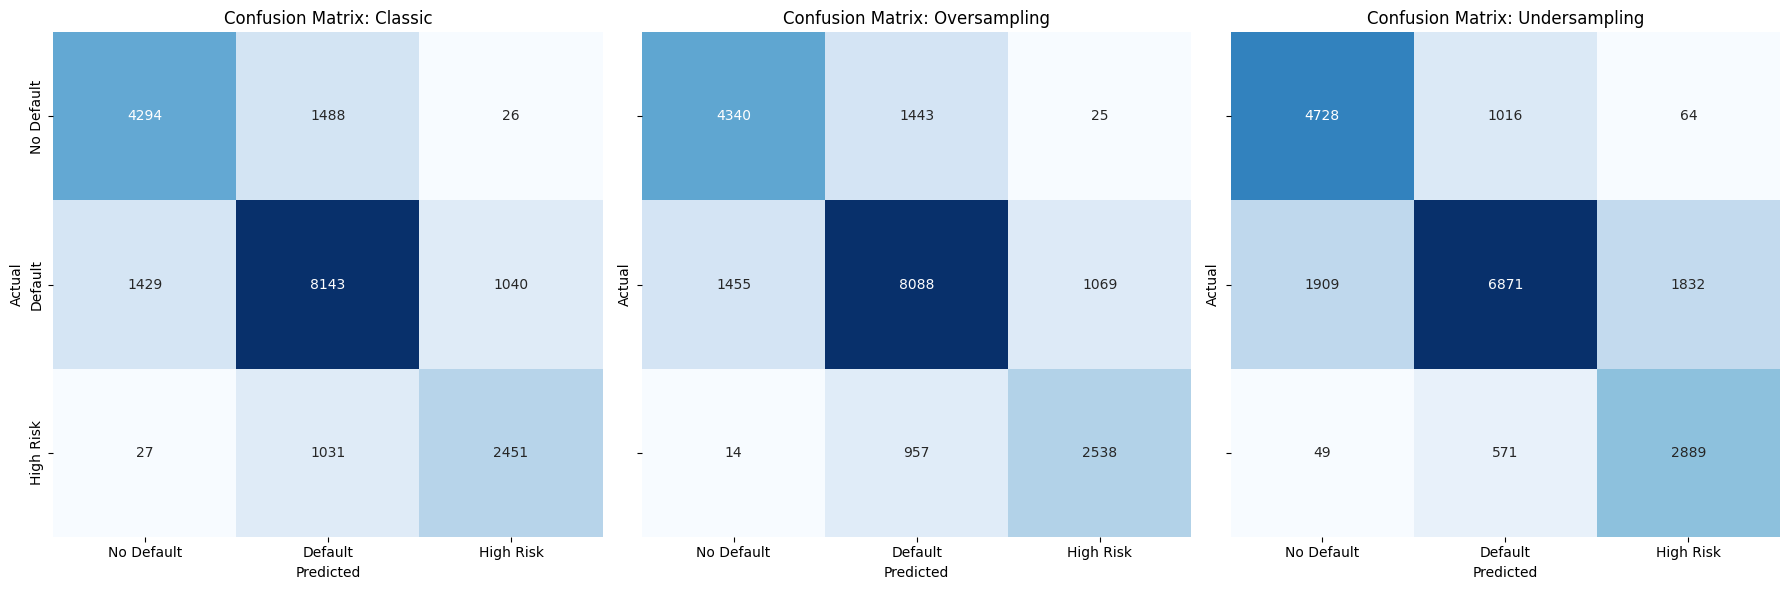

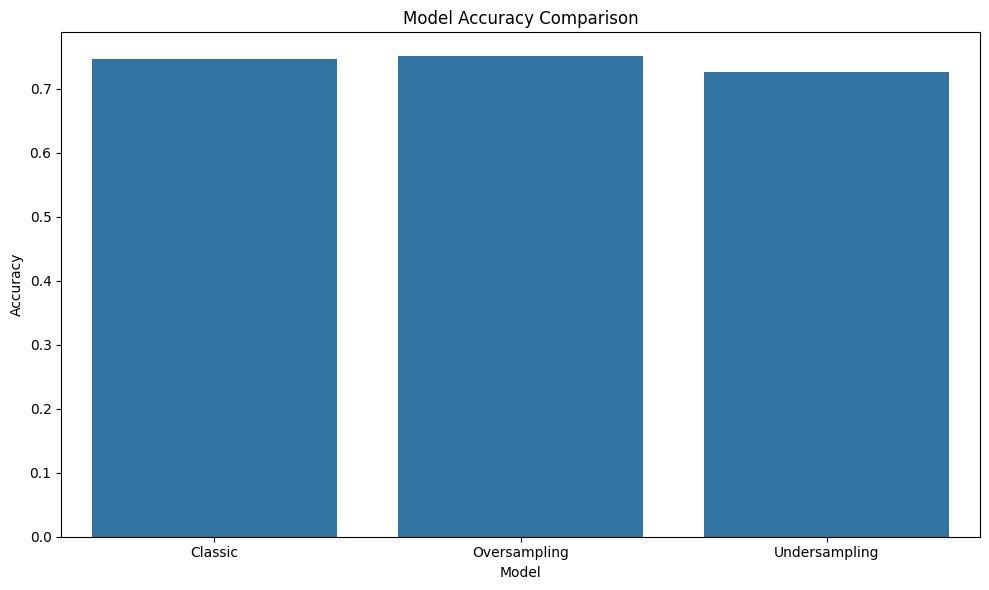

In [11]:
# Compute and display the confusion matrix for the models
confusion_matrix_result = confusion_matrix(y_test, y_pred)
confusion_matrix_result_over = confusion_matrix(y_test, y_pred_over)
confusion_matrix_result_under = confusion_matrix(y_test, y_pred_under)

# Storing the confusion matrices in a dictionary for easy access
confusion_matrices = {
    'Classic': confusion_matrix_result,
    'Oversampling': confusion_matrix_result_over,
    'Undersampling': confusion_matrix_result_under
}

# Plotting the confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (model_name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Default', 'Default', 'High Risk'],
                yticklabels=['No Default', 'Default', 'High Risk'],
                ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Represent the results in a DataFrame
results = pd.DataFrame({
    'Model': ['Classic', 'Oversampling', 'Undersampling'],
    'Accuracy': [
        decision_tree_model.score(X_test, y_test),
        decision_tree_model_over.score(X_test, y_test),
        decision_tree_model_under.score(X_test, y_test)
    ]
})
# Display the results in a table

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


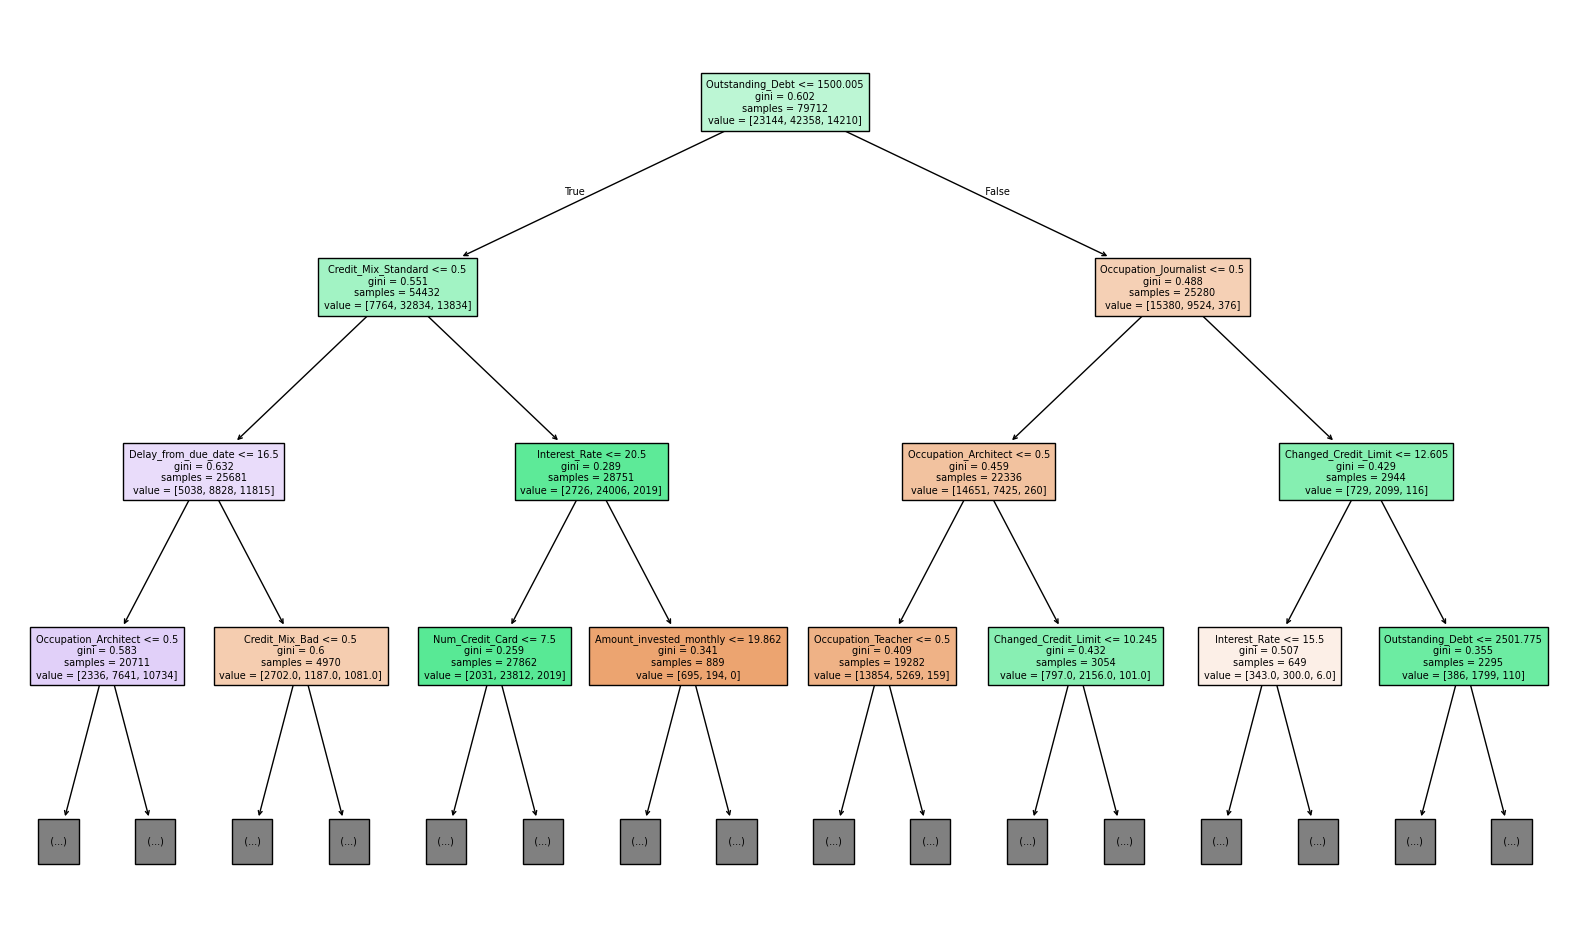

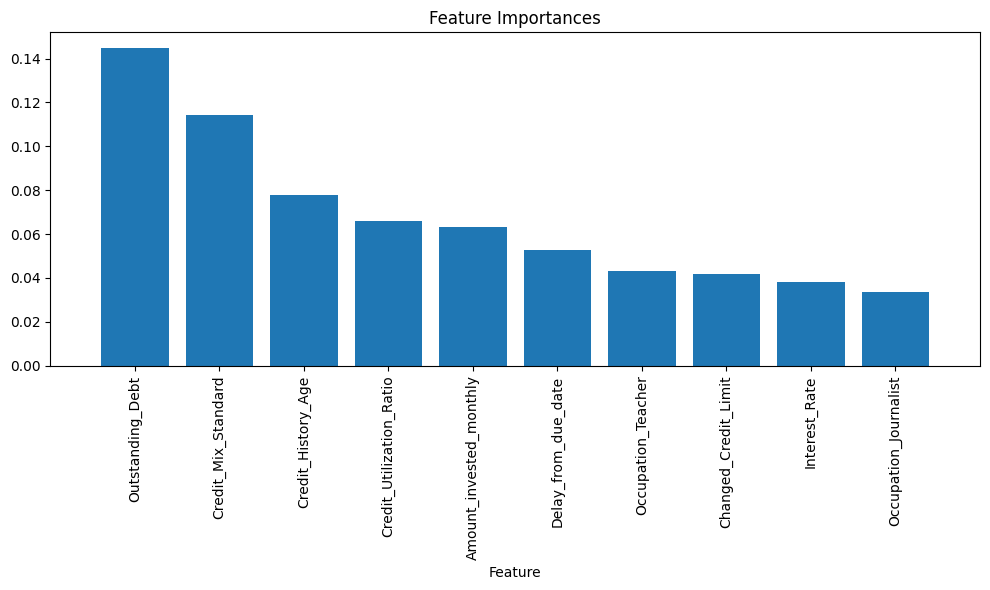

In [12]:
# Visualizing the Decision Tree with a maximum depth of 3
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 12))  # Increased figure size for better readability
plt.title("Decision Tree Visualization (max_depth=3)", fontsize=16)
plot_tree(decision_tree_model, filled=True, feature_names=X.columns, max_depth=3, fontsize=7)
plt.show()

# Feature Importance
importances = decision_tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
importances = importances[indices]

# Plotting the feature importances (top 10)
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


## 5) Random Forest Classifier

Random forests are an ensemble learning method that combines multiple decision trees to improve the model's performance and reduce overfitting. By aggregating the predictions of multiple trees, random forests can provide more accurate and robust predictions than a single decision tree.

In [13]:
# Define the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data without oversampling or undersampling
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Random Forest) without oversampling or undersampling:")
print(classification_report(y_test, y_pred_rf))

Classification Report (Random Forest) without oversampling or undersampling:
              precision    recall  f1-score   support

           1       0.79      0.86      0.82      5808
           2       0.84      0.81      0.83     10612
           3       0.79      0.78      0.78      3509

    accuracy                           0.82     19929
   macro avg       0.81      0.81      0.81     19929
weighted avg       0.82      0.82      0.82     19929



In [14]:
# Define the Random Forest model
random_forest_model_over = RandomForestClassifier(random_state=42)

# Fit the model to the training data with oversampling
random_forest_model_over.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_rf_over = random_forest_model_over.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Random Forest) with oversampling:")
print(classification_report(y_test, y_pred_rf_over))

Classification Report (Random Forest) with oversampling:
              precision    recall  f1-score   support

           1       0.78      0.87      0.82      5808
           2       0.85      0.79      0.82     10612
           3       0.77      0.80      0.79      3509

    accuracy                           0.82     19929
   macro avg       0.80      0.82      0.81     19929
weighted avg       0.82      0.82      0.82     19929



In [15]:
# Define the Random Forest model
random_forest_model_under = RandomForestClassifier(random_state=42, max_features=10)

# Fit the model to the training data with undersampling
random_forest_model_under.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred_rf_under = random_forest_model_under.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Random Forest) with undersampling:")
print(classification_report(y_test, y_pred_rf_under))

Classification Report (Random Forest) with undersampling:
              precision    recall  f1-score   support

           1       0.77      0.90      0.83      5808
           2       0.89      0.73      0.80     10612
           3       0.71      0.88      0.79      3509

    accuracy                           0.81     19929
   macro avg       0.79      0.84      0.81     19929
weighted avg       0.82      0.81      0.81     19929



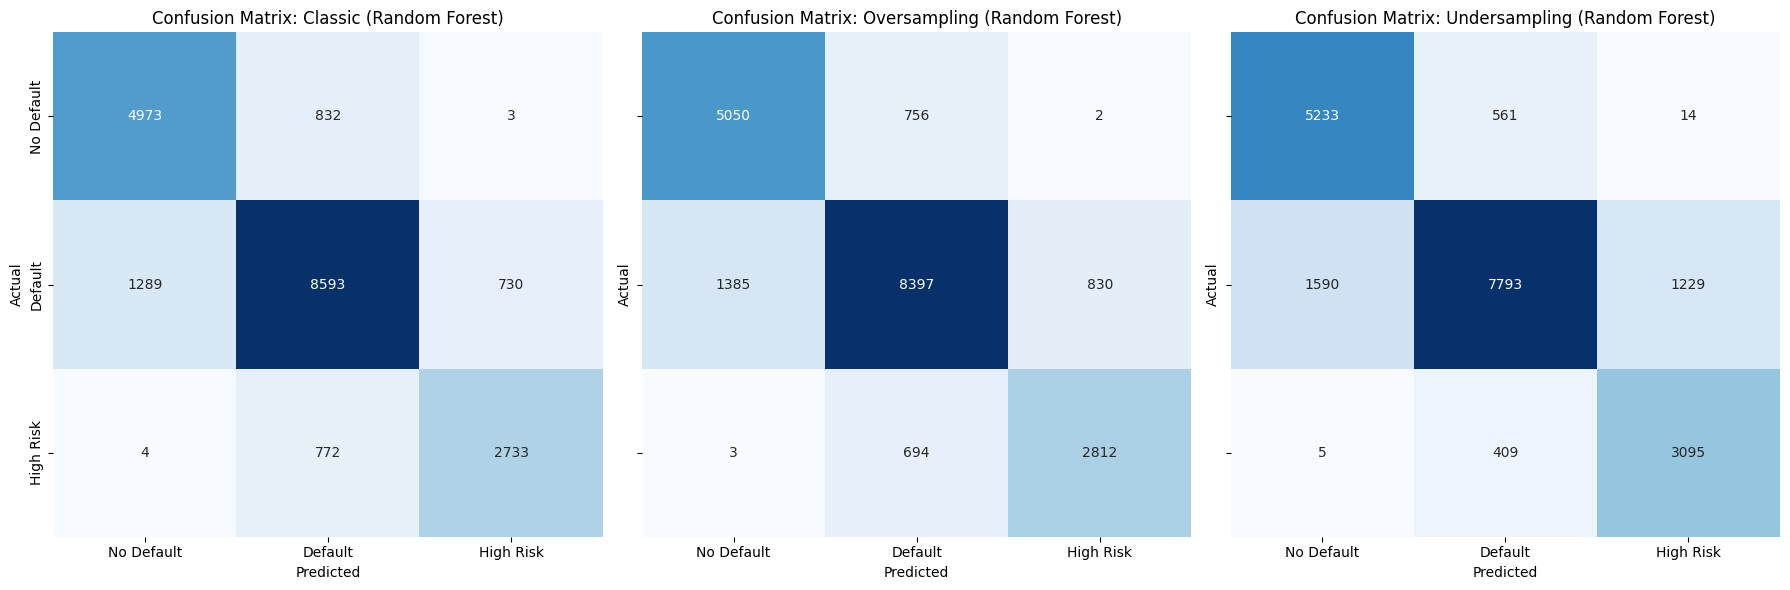

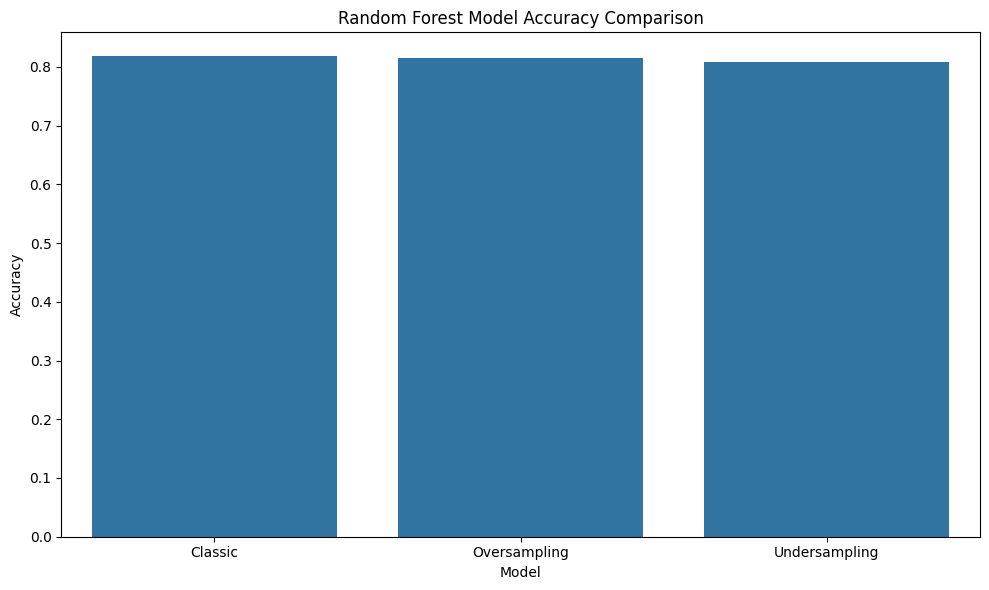

In [16]:
# Compute and display the confusion matrix for the Random Forest models
confusion_matrix_rf_result = confusion_matrix(y_test, y_pred_rf)
confusion_matrix_rf_result_over = confusion_matrix(y_test, y_pred_rf_over)
confusion_matrix_rf_result_under = confusion_matrix(y_test, y_pred_rf_under)

# Storing the confusion matrices in a dictionary for easy access
confusion_matrices_rf = {
    'Classic': confusion_matrix_rf_result,
    'Oversampling': confusion_matrix_rf_result_over,
    'Undersampling': confusion_matrix_rf_result_under
}

# Plotting the confusion matrices side by side for Random Forest models
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (model_name, cm) in zip(axes, confusion_matrices_rf.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Default', 'Default', 'High Risk'],
                yticklabels=['No Default', 'Default', 'High Risk'],
                ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name} (Random Forest)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Represent the results in a DataFrame for Random Forest models
results_rf = pd.DataFrame({
    'Model': ['Classic', 'Oversampling', 'Undersampling'],
    'Accuracy': [
        random_forest_model.score(X_test, y_test),
        random_forest_model_over.score(X_test, y_test),
        random_forest_model_under.score(X_test, y_test)
    ]
})
# Display the results in a table for Random Forest models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_rf)
plt.title('Random Forest Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

## 6) Gradient Boosting Classifier
Gradient boosting is another ensemble learning method that builds a series of decision trees in a sequential manner. Each tree is trained to correct the errors made by the previous trees, allowing the model to learn complex patterns in the data. Gradient boosting can be more sensitive to overfitting than random forests, but it often achieves better performance on certain tasks.

In [17]:
# Define the Gradient Boosting model (using all features by default)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data without oversampling or undersampling
gradient_boosting_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gradient_boosting_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Gradient Boosting) without oversampling or undersampling:")
print(classification_report(y_test, y_pred_gb))


Classification Report (Gradient Boosting) without oversampling or undersampling:
              precision    recall  f1-score   support

           1       0.80      0.80      0.80      5808
           2       0.80      0.83      0.81     10612
           3       0.79      0.71      0.75      3509

    accuracy                           0.80     19929
   macro avg       0.80      0.78      0.79     19929
weighted avg       0.80      0.80      0.80     19929



In [18]:
# Define the Gradient Boosting model (using all features by default)
gradient_boosting_model_over = GradientBoostingClassifier(random_state=42)

# Fit the model to the oversampled training data
gradient_boosting_model_over.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_gb_over = gradient_boosting_model_over.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Gradient Boosting) with oversampling:")
print(classification_report(y_test, y_pred_gb_over))

Classification Report (Gradient Boosting) with oversampling:
              precision    recall  f1-score   support

           1       0.79      0.83      0.81      5808
           2       0.82      0.79      0.81     10612
           3       0.73      0.76      0.74      3509

    accuracy                           0.80     19929
   macro avg       0.78      0.79      0.79     19929
weighted avg       0.80      0.80      0.80     19929



In [19]:
# Define the Gradient Boosting model (using all features by default)
gradient_boosting_model_under = GradientBoostingClassifier(random_state=42)

# Fit the model to the undersampled training data
gradient_boosting_model_under.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred_gb_under = gradient_boosting_model_under.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Gradient Boosting) with undersampling:")
print(classification_report(y_test, y_pred_gb_under))


Classification Report (Gradient Boosting) with undersampling:
              precision    recall  f1-score   support

           1       0.78      0.85      0.81      5808
           2       0.85      0.72      0.78     10612
           3       0.62      0.82      0.71      3509

    accuracy                           0.78     19929
   macro avg       0.75      0.80      0.77     19929
weighted avg       0.79      0.78      0.78     19929



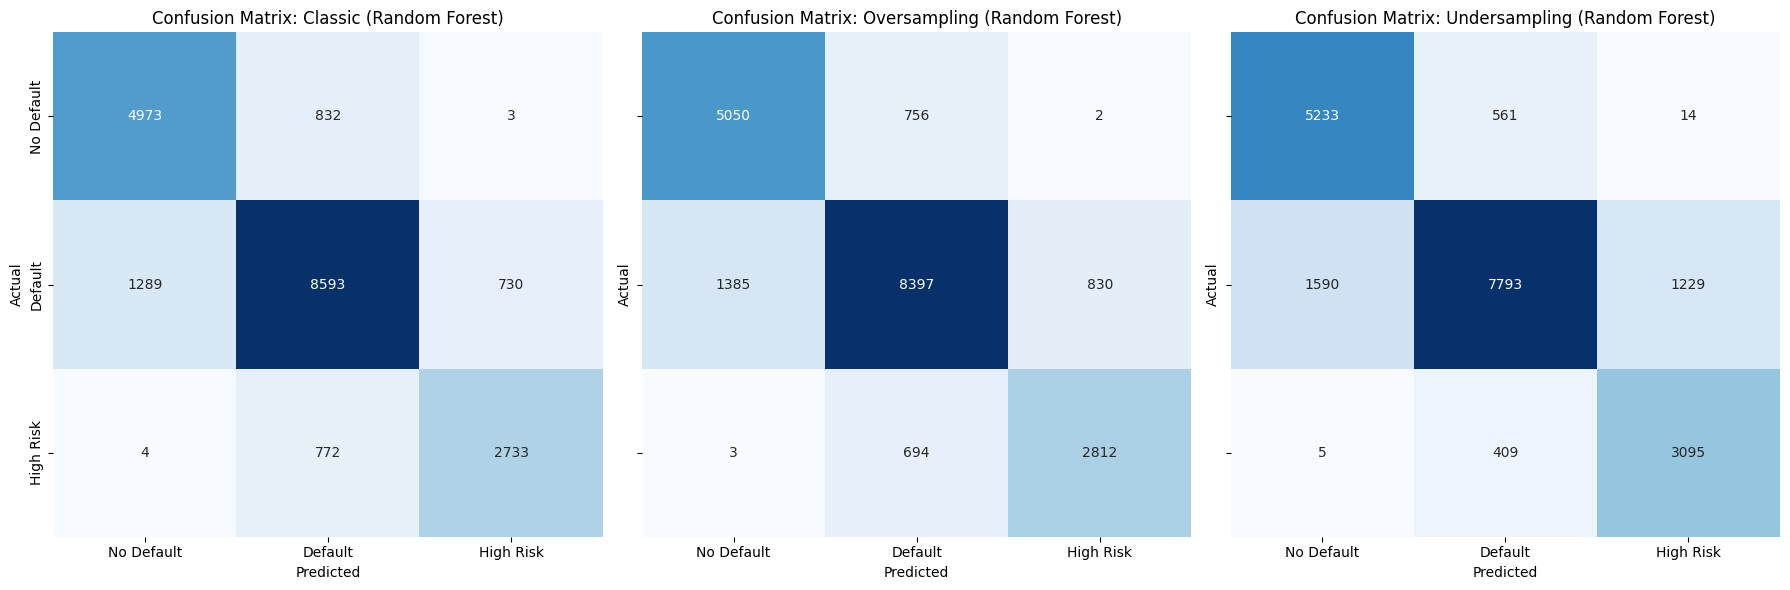

Text(0.5, 1.0, 'Random Forest Model Accuracy Comparison')

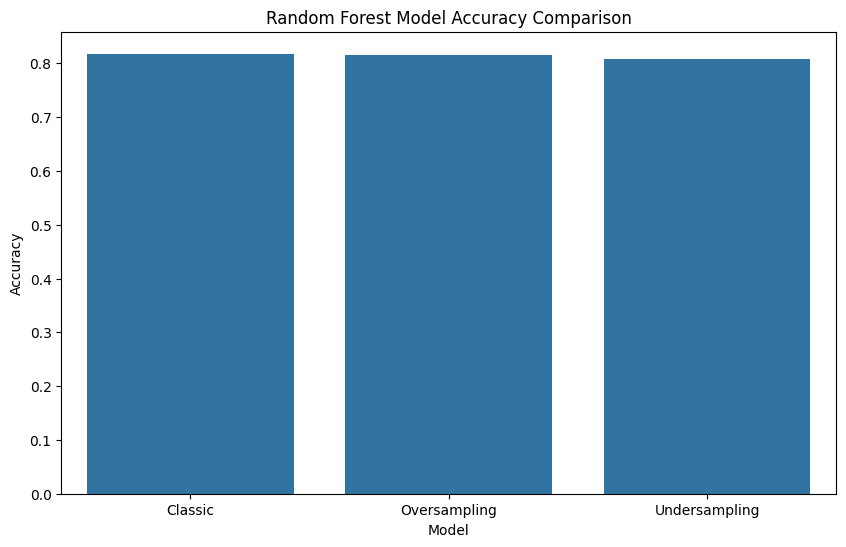

In [21]:
# Compute and display the confusion matrix for the Random Forest models
confusion_matrix_rf_result = confusion_matrix(y_test, y_pred_rf)
confusion_matrix_rf_result_over = confusion_matrix(y_test, y_pred_rf_over)
confusion_matrix_rf_result_under = confusion_matrix(y_test, y_pred_rf_under)

# Storing the confusion matrices in a dictionary for easy access
confusion_matrices_rf = {
    'Classic': confusion_matrix_rf_result,
    'Oversampling': confusion_matrix_rf_result_over,
    'Undersampling': confusion_matrix_rf_result_under
}

# Plotting the confusion matrices side by side for Random Forest models
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (model_name, cm) in zip(axes, confusion_matrices_rf.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Default', 'Default', 'High Risk'],
                yticklabels=['No Default', 'Default', 'High Risk'],
                ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name} (Random Forest)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Represent the results in a DataFrame for Random Forest models
results_rf = pd.DataFrame({
    'Model': ['Classic', 'Oversampling', 'Undersampling'],
    'Accuracy': [
        random_forest_model.score(X_test, y_test),
        random_forest_model_over.score(X_test, y_test),
        random_forest_model_under.score(X_test, y_test)
    ]
})

# Display the results in a table for Random Forest models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_rf)
plt.title('Random Forest Model Accuracy Comparison')

## 6) XGBoost Classifier
XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting that is designed to be highly efficient and scalable. It includes features such as parallel processing, regularization, and tree pruning, which can lead to faster training times and improved performance compared to traditional gradient boosting methods.

In [35]:
# Define the Gradient Boosting model (using all features by default)
gradient_boosting_model_over = XGBClassifier()

# Map the target variable
y_train_mapped = y_train_over.map( {1: 0, 2: 1, 3: 2})
y_test_mapped = y_test.map({1: 0, 2: 1, 3: 2})

# Fit the model to the oversampled training data
gradient_boosting_model_over.fit(X_train_over, y_train_mapped)

# Make predictions on the test set
y_pred_gb_over = gradient_boosting_model_over.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Gradient Boosting) with oversampling:")
print(classification_report(y_test_mapped, y_pred_gb_over)) 

Classification Report (Gradient Boosting) with oversampling:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      5808
           1       0.84      0.80      0.82     10612
           2       0.77      0.76      0.76      3509

    accuracy                           0.81     19929
   macro avg       0.80      0.81      0.80     19929
weighted avg       0.81      0.81      0.81     19929



## 7) Hyperparameter Tuning on the Best Model
Hyperparameter tuning is the process of optimizing the parameters of a machine learning model to improve its performance. In this case, we will use **GridSearchCV** to perform hyperparameter tuning on the best-performing model from the previous step. GridSearchCV systematically searches through a specified set of hyperparameters and evaluates the model's performance using cross-validation.

In [27]:
# Selecting the values for each hyperparameter
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Map classes from [1, 2, 3] → [0, 1, 2]
y_train_mapped = y_train_over.map({1: 0, 2: 1, 3: 2})
y_test_mapped = y_test.map({1: 0, 2: 1, 3: 2})


grid_search.fit(X_train_over, y_train_mapped)
xg_model_tuned = grid_search.best_estimator_
y_pred_xg = xg_model_tuned.predict(X_test)

print("Classification Report (Tuned XGBoost):")
print(classification_report(y_test_mapped, y_pred_xg))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\miche\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\miche\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\miche\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\miche\AppData\Local\Programs\Python\Py

Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      5808
           1       0.84      0.80      0.82     10612
           2       0.77      0.76      0.77      3509

    accuracy                           0.81     19929
   macro avg       0.80      0.81      0.80     19929
weighted avg       0.81      0.81      0.81     19929



In [32]:
from imblearn.under_sampling import RandomUnderSampler

# 2.1 – scegli la strategia
rus = RandomUnderSampler(
    sampling_strategy = 'majority',   # riduce SOLO la classe più numerosa di 1/3
    random_state=42
)

# 2.2 – modello
clf_under = DecisionTreeClassifier(random_state=42, max_features=10)

# 2.3 – pipeline: under-sampler → modello
pipe_under = Pipeline([
    ('under', rus),
    ('model', clf_under)
])


In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe_under,
    X_train_orig, y_train_orig,
    cv=cv,
    scoring='f1_macro'
)
print(f"F1-macro (undersampling)   : {scores.mean():.3f} ± {scores.std():.3f}")

# Fit finale e test reale
pipe_under.fit(X_train_orig, y_train_orig)
y_pred_under = pipe_under.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion matrix (undersampling):")
print(confusion_matrix(y_test, y_pred_under))

print("\nClassification report:")
print(classification_report(y_test, y_pred_under))


F1-macro (undersampling)   : 0.957 ± 0.001

Confusion matrix (undersampling):
[[5731  135    1]
 [ 353 9984  236]
 [   0   92 3398]]

Classification report:
              precision    recall  f1-score   support

           1       0.94      0.98      0.96      5867
           2       0.98      0.94      0.96     10573
           3       0.93      0.97      0.95      3490

    accuracy                           0.96     19930
   macro avg       0.95      0.96      0.96     19930
weighted avg       0.96      0.96      0.96     19930



In [34]:
pipe_under.fit(X_train_orig, y_train_orig)
y_pred_under = pipe_under.predict(X_test)


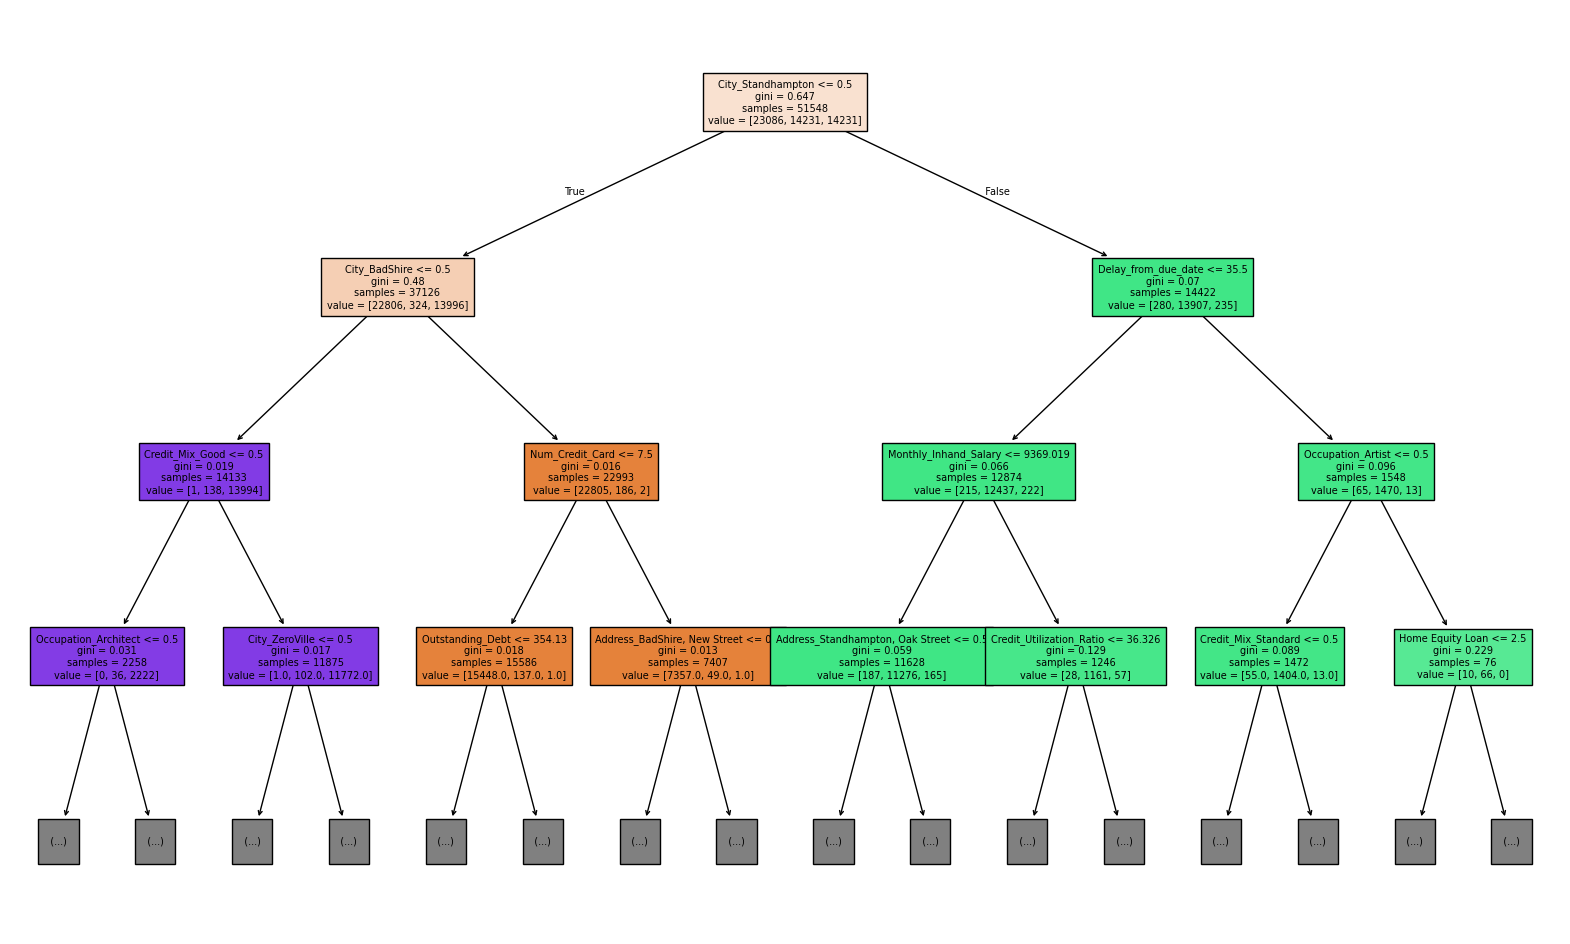

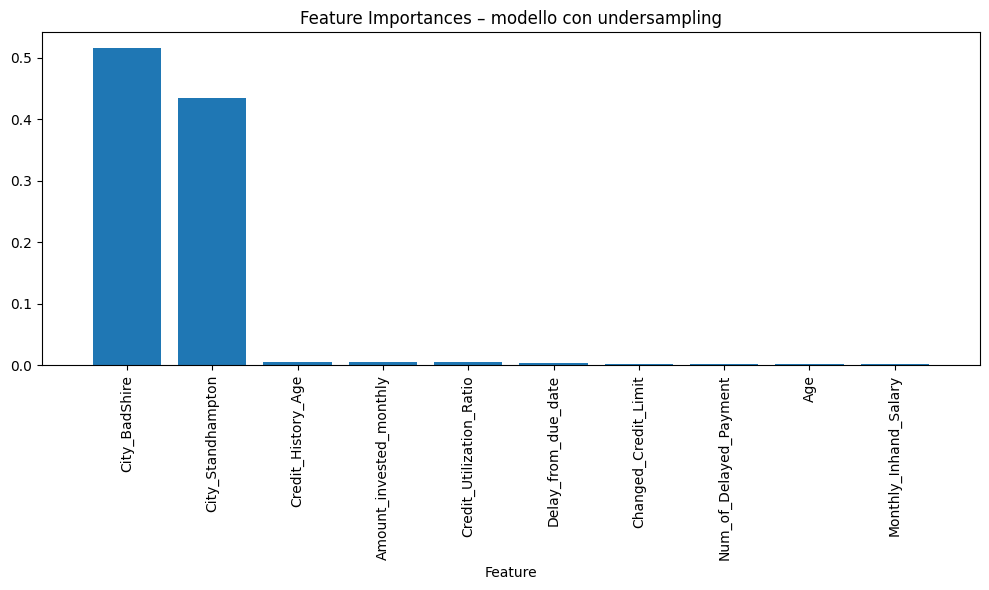

In [35]:
# ── 1. recupera l’albero addestrato ───────────────────────────────────────────
tree_model_under = pipe_under.named_steps['model']   # <─ l'albero già fit-tato

# ── 2. visualizza i primi 3 livelli dell’albero ───────────────────────────────
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.title("Decision Tree (undersampling) – max_depth = 3", fontsize=16)

plot_tree(
    tree_model_under,
    filled=True,
    feature_names=X.columns,   # o X_train_orig.columns se preferisci
    max_depth=3,
    fontsize=7
)
plt.show()

# ── 3. feature importances (top-10) ───────────────────────────────────────────
import numpy as np

importances = tree_model_under.feature_importances_
indices     = np.argsort(importances)[::-1]          # ordina desc
features    = X.columns[indices]                    # stesse feature-names
importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances – modello con undersampling")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


RandomForest + SMOTE  |  CV macro-F1: 0.981 ± 0.001

Confusion matrix (RandomForest):
[[ 5778    88     1]
 [  129 10362    82]
 [    0    60  3430]]

Classification report:
              precision    recall  f1-score   support

           1       0.98      0.98      0.98      5867
           2       0.99      0.98      0.98     10573
           3       0.98      0.98      0.98      3490

    accuracy                           0.98     19930
   macro avg       0.98      0.98      0.98     19930
weighted avg       0.98      0.98      0.98     19930



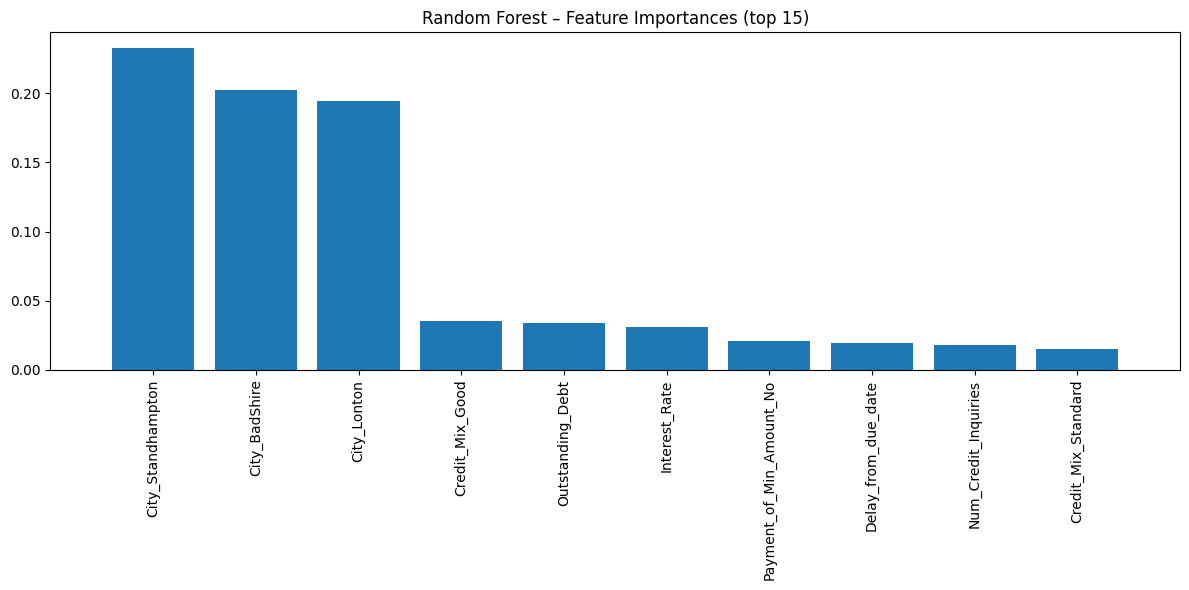

In [ ]:
# ------------------------------------------------------------------
# 1)  nuovo SMOTE + RandomForest nella stessa logica del vecchio modello
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,          # lascia crescere liberamente
    min_samples_leaf=2,      # piccolo smoothing delle foglie
    n_jobs=-1,
    random_state=42
)

pipe_rf = Pipeline([
    ('smote', smote),
    ('model', rf_clf)
])

# ------------------------------------------------------------------
# 2)  cross-validation (macro-F1) sul train oversamplato internamente
# ------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_rf = cross_val_score(
    pipe_rf, X_train, y_train,
    cv=cv, scoring='f1_macro'
)
print(f"RandomForest + SMOTE  |  CV macro-F1: {scores_rf.mean():.3f} ± {scores_rf.std():.3f}")

# ------------------------------------------------------------------
# 3)  fit finale e valutazione sul test vero (distribuzione reale)
# ------------------------------------------------------------------
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion matrix (RandomForest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification report:")
print(classification_report(y_test, y_pred_rf))

# ------------------------------------------------------------------
# 4)  feature importances (top-15) ---------------------------------
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

rf_model = pipe_rf.named_steps['model']           # attento: prendi l'estimator addestrato

importances = rf_model.feature_importances_
idx_sorted  = np.argsort(importances)[::-1]

features    = X.columns[idx_sorted]               # stesse colonne usate nel modello
importances = importances[idx_sorted]

plt.figure(figsize=(12, 6))
plt.title("Random Forest – Feature Importances (top 10)")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()
